In [2]:
from privacy_onion.layer_utils import (
    plot_kde,
    tpr_at_fpr,
    plot_roc,
    plot_kde_lira,
    plot_multi_roc,
    plot_kde_custom,
    tpr_at_threshold)

In [3]:

import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
os.chdir("../")
plt.style.use("plot_style.mplstyle")

MODEL_DIR = "trained_models"

In [16]:
pointsvmetrics = {}

In [6]:
def filter_points(exp_id, target, layer_folder, layer):
    lira_path = f"{MODEL_DIR}/lira_scores/{exp_id}_{target}_32"
    df = pd.read_csv(lira_path)

    points_path = f"{MODEL_DIR}/layer_target_indices/{layer_folder}/layer_{layer - 1}_full_safe.pkl"
    full_vuln = pd.read_pickle(points_path)
    print(len(full_vuln), "points in full vuln")

    filtered = df[df['og_idx'].isin(full_vuln['og_idx'])]
    path = f"{MODEL_DIR}/lira_scores/{exp_id}_{target}_filt_32"
    filtered.to_csv(path)
    return filtered

In [3]:
exp_ids = [
    f"kd"
]

for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")


Processing experiment: kd
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.00924  231  0.585946   0.905882  0.00924   

   threshold_at_fpr  
0         11.417054  
Accuracy 87.54
Num samples: 25000


## Ideal

In [ ]:
def filter_ideal(exp_id, layer_folder, layer):
    lira_path = f"{MODEL_DIR}/lira_scores/{exp_id}_target_32"
    df = pd.read_csv(lira_path)


    points_path = f"{MODEL_DIR}/layer_target_indices/{layer_folder}/layer_{layer - 1}_full_safe.pkl"
    full_vuln = pd.read_pickle(points_path)
    print([i for i in range(50000) if i not in full_vuln['og_idx'].values])

    filtered = df[df['og_idx'].isin(full_vuln['og_idx'])]
    
    return filtered

In [27]:
ideal_threshold = tpr_at_fpr("wrn28-2_CIFAR_5_l0", 0.001)["threshold_at_fpr"].values[0]

for layer in range(1,7):
    print("=="*50)
    print(f"Layer {layer}")
    df = filter_ideal("wrn28-2_CIFAR_5_l0", "wrn28-CIFAR_5", layer, ideal_threshold)
    print(tpr_at_threshold(df, ideal_threshold))
    

Layer 1
48750 points in filtered vuln
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.035074  833  0.654155   0.971995  0.035074   6.758952
Layer 2
47563 points in filtered vuln
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.025927  585  0.655346   0.960591  0.025927   6.758952
Layer 3
46435 points in filtered vuln
  attack  tpr_at_threshold  tps       auc  precision   recall  threshold
0   LiRA           0.02146  460  0.659294   0.950413  0.02146   6.758952
Layer 4
45364 points in filtered vuln
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.019102  389  0.663932   0.941889  0.019102   6.758952
Layer 5
44346 points in filtered vuln
  attack  tpr_at_threshold  tps       auc  precision    recall  threshold
0   LiRA          0.017368  336  0.668509   0.933333  0.017368   6.758952
Layer 6
43379 points in filtered vuln
  attack  tpr_at_threshold  tps   

In [7]:
# filter_points('ideal', 'CIFAR5_l1', 'wrn28-CIFAR_5', 1)
filter_points('ideal', 'CIFAR5_l5', 'wrn28-CIFAR_5', 5)

44346 points in full vuln


,og_idx,lira_score,target_trained_on
0,0,2.629090e+00,True
1,1,2.389681e+00,True
2,2,7.970024e-01,False
3,3,2.729740e+00,True
4,4,2.677521e+00,False
...,...,...,...
49994,49994,3.228683e+00,False
49995,49995,1.213255e-11,False
49996,49996,3.685696e-03,False
49998,49998,2.280154e+00,True


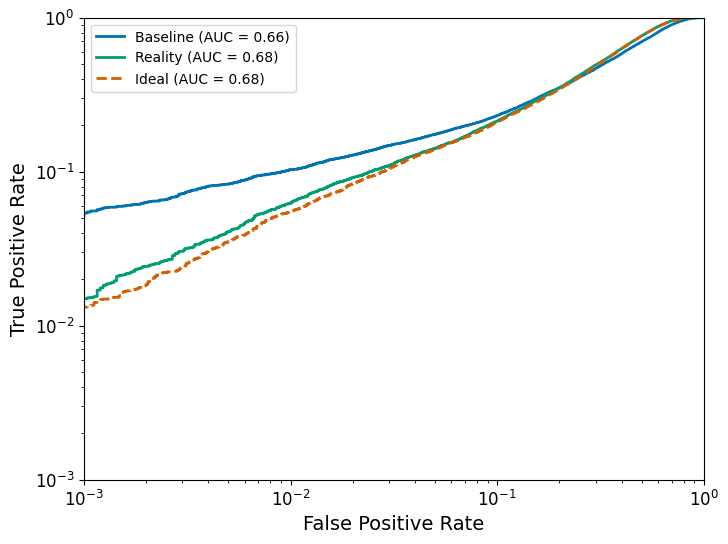

In [3]:
exp_ids = [("wrn28-2_CIFAR_5_l0", "target", "Baseline"),
           ("wrn28-2_CIFAR_5_l4", "target", "Reality"),
           ("ideal_CIFAR5_l4","filt", "Ideal")]


plot_multi_roc(exp_ids)

In [5]:
targets = [
    "CIFAR5_l1_filt",
]

for target in targets:
    print("=="*50)
    print(f"Processing experiment: {target}")
    tpr = tpr_at_fpr("ideal", fpr=0.001, target_id=target)
    print(tpr)

# overlay the ROCs
# to get ideal tpr, get threshold at fpr for each target and compare the true tpr at that threshold

Processing experiment: CIFAR5_l1_filt
  attack  tpr_at_fpr_0.001  tps      auc  precision    recall  \
0   LiRA          0.029053  690  0.65581   0.966387  0.029053   

   threshold_at_fpr  
0          7.703844  


## Remove top 5%

### CIFAR10

Processing experiment: wrn28-2_CIFAR_5_l0
  attack  tpr_at_fpr_0.001   tps      auc  precision   recall  \
0   LiRA           0.05044  1261  0.65502   0.981323  0.05044   

   threshold_at_fpr  
0          6.758952  
Accuracy 89.03
Num samples: 25000
Processing experiment: wrn28-2_CIFAR_5_l1
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.030021  713  0.658558   0.967436  0.030021   

   threshold_at_fpr  
0          8.231377  
Accuracy 88.08
Num samples: 23750
Processing experiment: wrn28-2_CIFAR_5_l2
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.027966  631  0.655201    0.96189  0.027966   

   threshold_at_fpr  
0          6.421025  
Accuracy 86.24
Num samples: 22563
Processing experiment: wrn28-2_CIFAR_5_l3
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall  \
0   LiRA           0.02062  442  0.670666   0.948498  0.02062   

   threshold_at_fpr  
0          8.051884  
Accuracy 84.61
Num samples

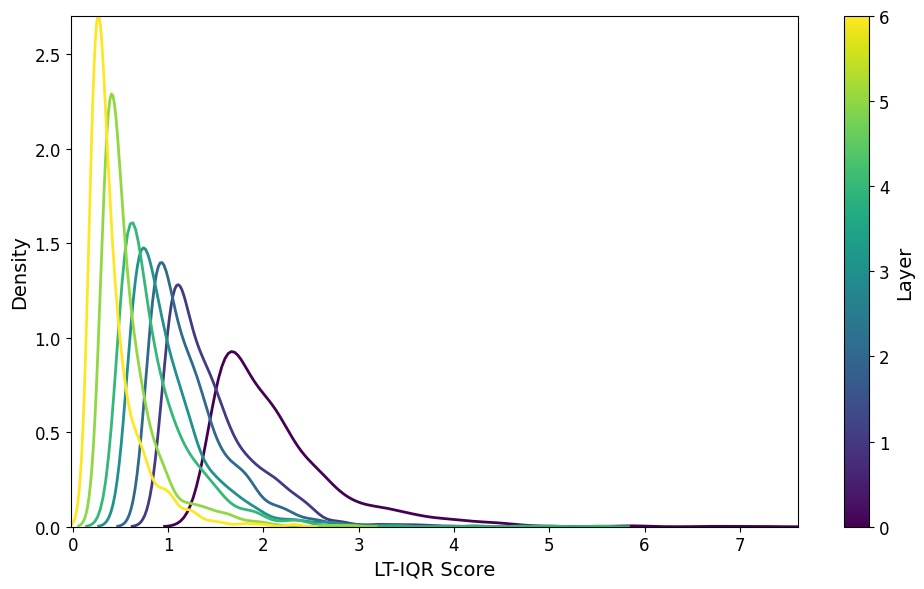

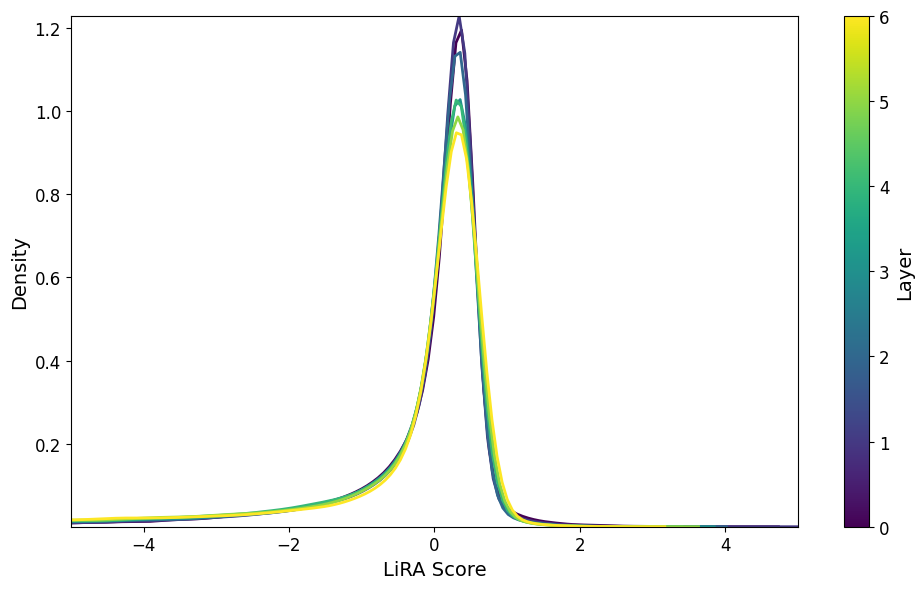

In [17]:
exp_ids = [
    f"wrn28-2_CIFAR_5_l{layer}" for layer in range(7)
]

for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
    if "Top 5%" not in pointsvmetrics:
        pointsvmetrics["Top 5%"] = []
    pointsvmetrics["Top 5%"].append({
        "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
        "acc": saves["test_acc"],
        "num_samples": len(saves["trained_on_indices"]),
    })

plot_kde(exp_ids, save_name="iter_removal_cifar5")
plot_kde_lira(exp_ids, save_name="iter_removal_cifar5_lira")


### CINIC10

In [ ]:
path1 = "/vol/bitbucket/vb524/lossv2/trained_models/layer_target_indices/cinictest/layer_0_safe.pkl"
path2 = "/vol/bitbucket/vb524/lossv2/trained_models/layer_target_indices/wrn28-CINIC/layer_0_safe.pkl"

import pickle as pkl
lira1 = pkl.load(open(path1, "rb"))
lira2 = pkl.load(open(path2, "rb"))

diff = set(lira1.values) - set(lira2.values)
print(f"Difference in points: {len(diff)}")



Difference in points: 2160


In [18]:
set(trained_points["cinictest"]) - set(trained_points["wrn28-2_CINIC_l0"])

set()

In [15]:
exp_ids = [
    f"cinictest", "wrn28-2_CINIC_l0"
]
trained_points = {}
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    trained_points[exp_id] = saves['trained_on_indices']
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")

Processing experiment: cinictest
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.106844  4808  0.772741   0.990932  0.106844   

   threshold_at_fpr  
0          6.470314  
Accuracy 81.23
Num samples: 45000
Processing experiment: wrn28-2_CINIC_l0
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.021578  971  0.628915    0.95665  0.021578   

   threshold_at_fpr  
0         12.597131  
Accuracy 66.83
Num samples: 45000


In [4]:
exp_ids = [
    f"wrn28-2_CINIC_l{layer}" for layer in range(7)
]

for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    # tpr = tpr_at_fpr(exp_id, fpr=0.001)
    # print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
#     if "Top 5%" not in pointsvmetrics:
#         pointsvmetrics["Top 5%"] = []
#     pointsvmetrics["Top 5%"].append({
#         "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
#         "acc": saves["test_acc"],
#         "num_samples": len(saves["trained_on_indices"]),
#     })

# plot_kde(exp_ids, save_name="iter_removal_cifar5")
# plot_kde_lira(exp_ids, save_name="iter_removal_cifar5_lira")


Processing experiment: wrn28-2_CINIC_l0
Accuracy 66.83
Num samples: 45000
Processing experiment: wrn28-2_CINIC_l1
Accuracy 66.30
Num samples: 42750
Processing experiment: wrn28-2_CINIC_l2
Accuracy 65.03
Num samples: 40613
Processing experiment: wrn28-2_CINIC_l3
Accuracy 64.52
Num samples: 38583
Processing experiment: wrn28-2_CINIC_l4
Accuracy 63.82
Num samples: 36654
Processing experiment: wrn28-2_CINIC_l5
Accuracy 61.55
Num samples: 34822
Processing experiment: wrn28-2_CINIC_l6
Accuracy 62.80
Num samples: 33081


## Remove top 2.5%

### CIFAR10

Processing experiment: wrn28-2_CIFAR_5_l0
  attack  tpr_at_fpr_0.001   tps      auc  precision   recall  \
0   LiRA           0.05044  1261  0.65502   0.981323  0.05044   

   threshold_at_fpr  
0          6.758952  
Accuracy 89.03
Num samples: 25000
Processing experiment: wrn28-2_CIFAR_2_l1
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.038769  945  0.674336   0.974227  0.038769   

   threshold_at_fpr  
0          5.919425  
Accuracy 88.60
Num samples: 24375
Processing experiment: wrn28-2_CIFAR_2_l2
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.033619  799  0.657719   0.970838  0.033619   

   threshold_at_fpr  
0          7.394836  
Accuracy 88.02
Num samples: 23766
Processing experiment: wrn28-2_CIFAR_2_l3
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall  \
0   LiRA          0.026541  615  0.655361   0.962441  0.026541   

   threshold_at_fpr  
0          7.861309  
Accuracy 86.78
Num sampl

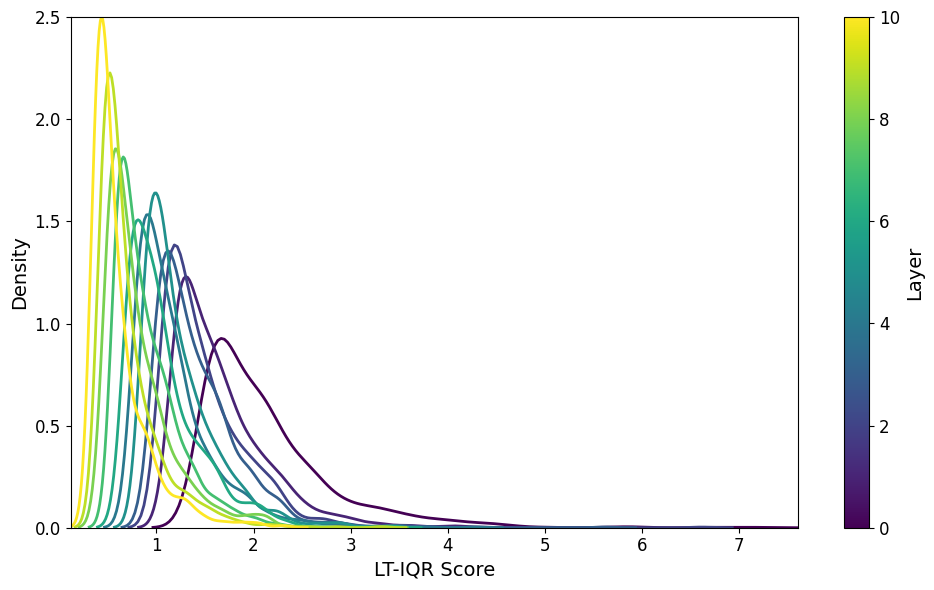

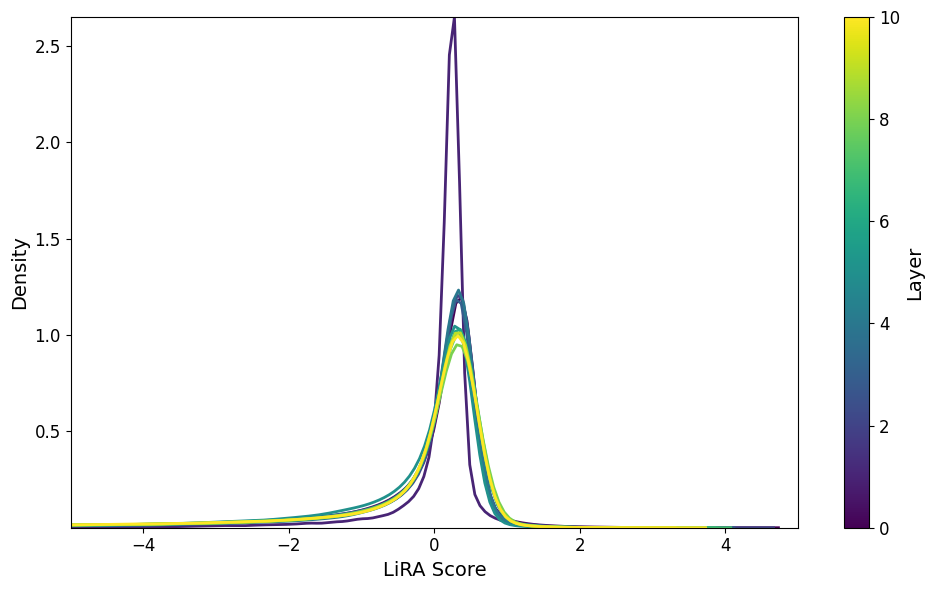

In [18]:
exp_ids = [
    f"wrn28-2_CIFAR_2_l{layer}" for layer in range(1,11)
]
exp_ids.insert(0, "wrn28-2_CIFAR_5_l0")

for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
    if "Top 2.5%" not in pointsvmetrics:
        pointsvmetrics["Top 2.5%"] = []
    pointsvmetrics["Top 2.5%"].append({
        "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
        "acc": saves["test_acc"],
        "num_samples": len(saves["trained_on_indices"]),
    })
plot_kde(exp_ids, save_name="iter_removal_cifar2")
plot_kde_lira(exp_ids)


## Gradient Clipping

Processing experiment: wrn28-2_CIFAR10_c_10
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall
0   LiRA           0.02164  541  0.651189   0.957522  0.02164
Accuracy 86.55
Processing experiment: wrn28-2_CIFAR10_c_3
  attack  tpr_at_fpr_0.001  tps       auc  precision   recall
0   LiRA           0.00852  213  0.620696   0.898734  0.00852
Accuracy 81.89


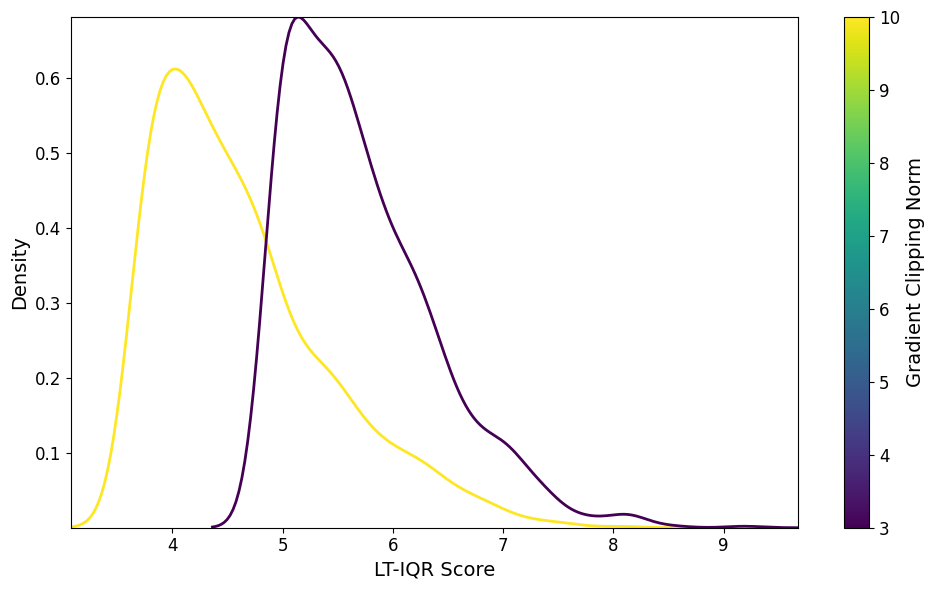

In [6]:
exp_ids = ["wrn28-2_CIFAR10_c_10", "wrn28-2_CIFAR10_c_3"]
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    # plot_roc(exp_id, fpr=0.001, tpr=0.9, plot=True)
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")

plot_kde_custom(exp_ids, labels=[10, 3], label_name="Gradient Clipping Norm", save_name="cifar10_clipping")




Processing experiment: wrn28-2_CIFAR10_rand_l0
  attack  tpr_at_fpr_0.001   tps      auc  precision   recall  \
0   LiRA           0.05316  1329  0.67461   0.982262  0.05316   

   threshold_at_fpr  
0           5.40769  
Accuracy 89.03
Num samples: 25000
Processing experiment: wrn28-2_CIFAR10_rand_l1


  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.053642  1274  0.681493    0.98151  0.053642   

   threshold_at_fpr  
0          5.545747  
Accuracy 88.36
Num samples: 23750
Processing experiment: wrn28-2_CIFAR10_rand_l2
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.045473  1026  0.667088   0.976213  0.045473   

   threshold_at_fpr  
0          5.364013  
Accuracy 87.58
Num samples: 22563
Processing experiment: wrn28-2_CIFAR10_rand_l3
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.059622  1278  0.688124   0.981567  0.059622   

   threshold_at_fpr  
0          5.188622  
Accuracy 88.95
Num samples: 21435
Processing experiment: wrn28-2_CIFAR10_rand_l4
  attack  tpr_at_fpr_0.001   tps       auc  precision    recall  \
0   LiRA          0.055736  1135  0.691302   0.979292  0.055736   

   threshold_at_fpr  
0          5.581457  
Accuracy 88.44
Num samples: 20364
Process

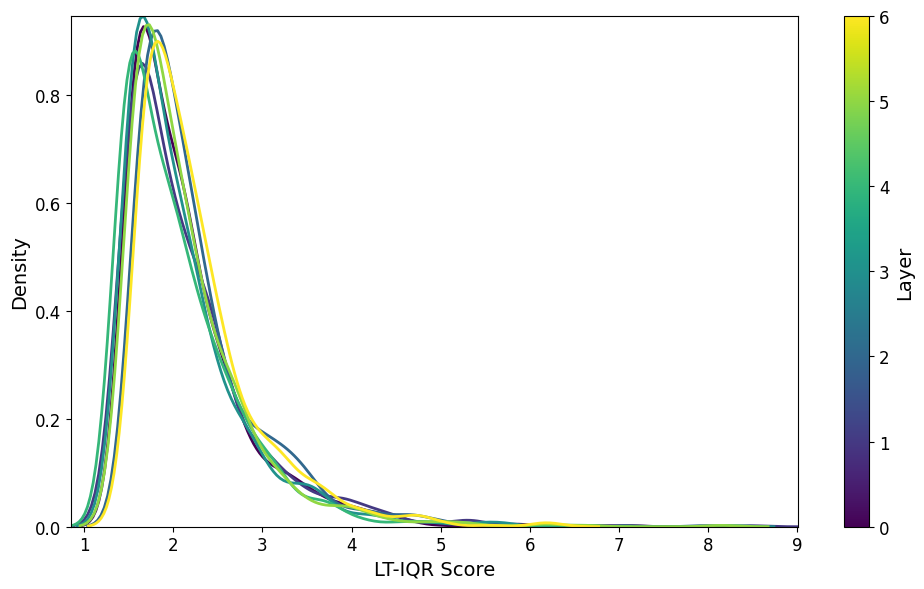

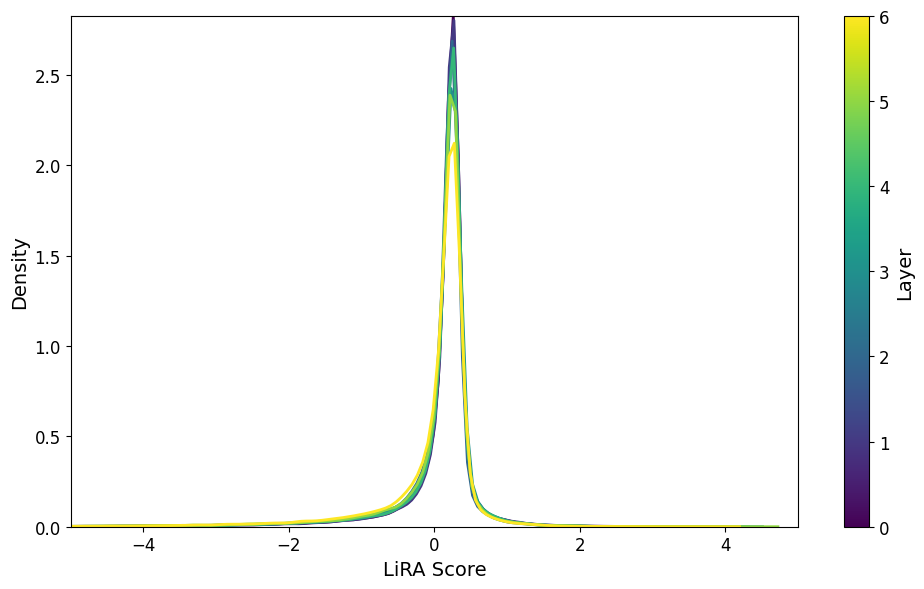

In [19]:
exp_ids = [
    f"wrn28-2_CIFAR10_rand_l{layer}" for layer in range(7)
]
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")
    if "Random 5%" not in pointsvmetrics:
        pointsvmetrics["Random 5%"] = []
    pointsvmetrics["Random 5%"].append({
        "tpr": tpr["tpr_at_fpr_0.001"].iloc[0],
        "acc": saves["test_acc"],
        "num_samples": len(saves["trained_on_indices"]),
    })

plot_kde(exp_ids, save_name="iter_removal_cifar10_rand")
plot_kde_lira(exp_ids, save_name="iter_removal_cifar10_rand_lira")


## KD

Processing experiment: kd
  attack  tpr_at_fpr_0.001  tps      auc  precision   recall
0   LiRA           0.00288   72  0.55309       0.75  0.00288
Accuracy 0.88
Num samples: 25000
Processing experiment: kd_0_mask
  attack  tpr_at_fpr_0.001  tps       auc  precision  recall
0   LiRA             0.006  150  0.552061   0.857143   0.006
Accuracy 86.97
Num samples: 25000


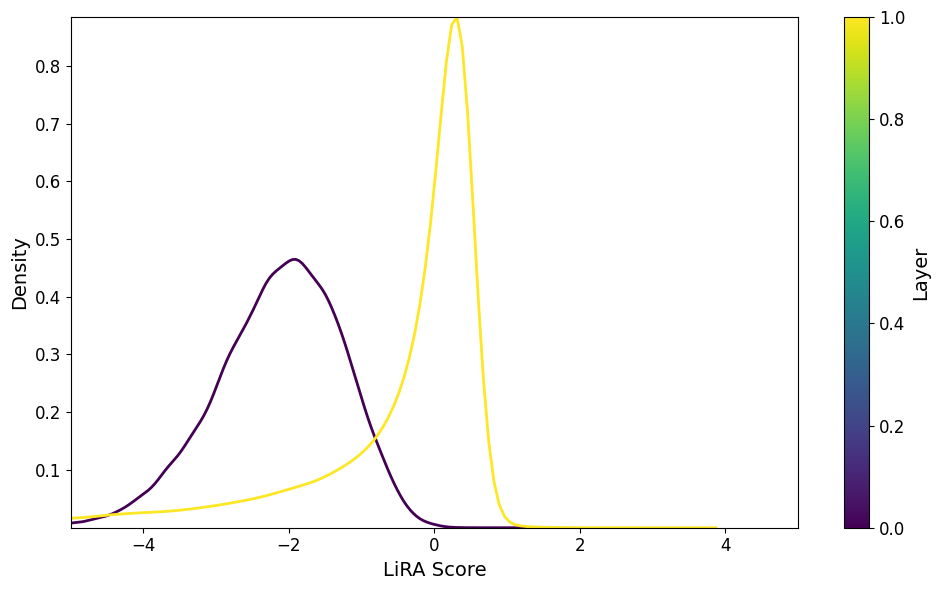

(<Figure size 1000x600 with 2 Axes>,
 <Axes: xlabel='LiRA Score', ylabel='Density'>)

In [11]:
exp_ids = [
    "kd", "kd_0_mask"
]
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")

# plot_kde_custom(exp_ids, labels=[0.5,0], label_name="Confidence Masking Strength", save_name="cifar10_kd")
# plot_kde_lira(exp_ids)

## Clustering

In [12]:
exp_ids = [
"wrn28-2_CIFAR10_cluster"
]
for exp_id in exp_ids:
    print("=="*50)
    print(f"Processing experiment: {exp_id}")
    tpr = tpr_at_fpr(exp_id, fpr=0.001)
    print(tpr)
    saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)
    print(f"Accuracy {saves['test_acc']:.2f}")
    print(f"Num samples: {len(saves['trained_on_indices'])}")

Processing experiment: wrn28-2_CIFAR10_cluster
  attack  tpr_at_fpr_0.001  tps       auc  precision    recall
0   LiRA          0.025979  570  0.671479   0.959596  0.025979
Accuracy 86.71
Num samples: 21941


## Trained Points vs Acc and TPR

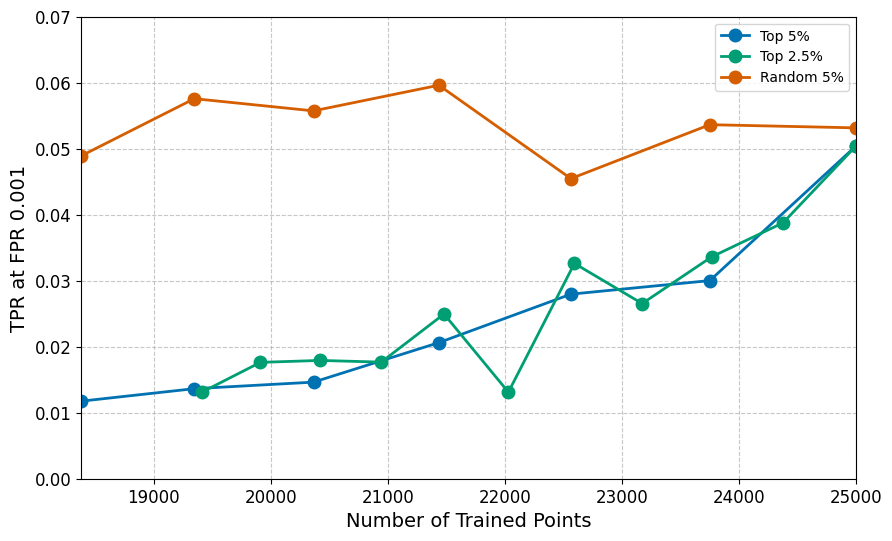

In [20]:
plt.figure(figsize=(10, 6))
for label, metrics in pointsvmetrics.items():
    tpr_values = [m["tpr"] for m in metrics]
    num_samples = [m["num_samples"] for m in metrics]
    plt.plot(num_samples, tpr_values, marker='o', label=label, markersize=9)
plt.xlabel("Number of Trained Points")
plt.ylabel("TPR at FPR 0.001")
plt.legend()
plt.ylim(0,0.07)    
plt.grid(linestyle='--', alpha=0.7)
plt.savefig("./figures/pointsvstpr.png", bbox_inches='tight', dpi=300)



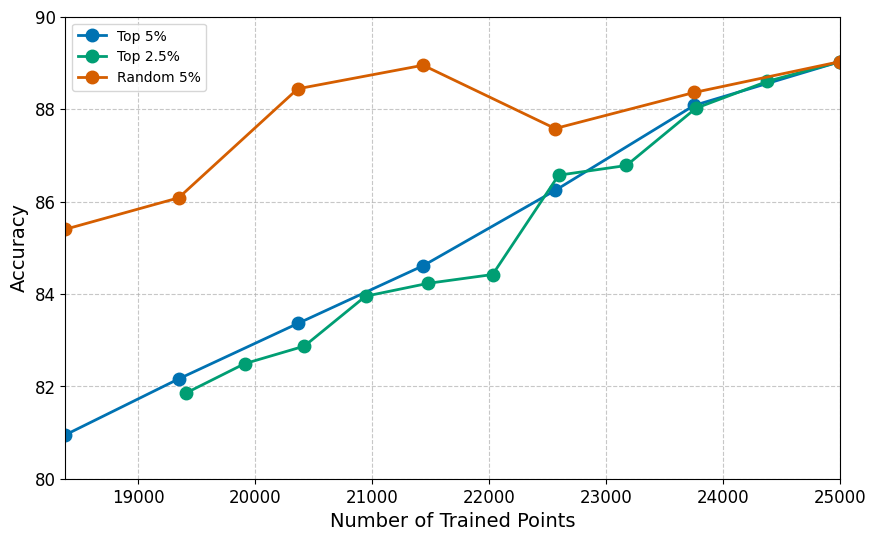

In [21]:
plt.figure(figsize=(10, 6))
for label, metrics in pointsvmetrics.items():
    acc = [m["acc"] for m in metrics]
    num_samples = [m["num_samples"] for m in metrics]
    plt.plot(num_samples, acc, marker='o', label=label, markersize=9)
plt.xlabel("Number of Trained Points")
plt.ylabel("Accuracy")
plt.ylim(80, 90)
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.savefig("./figures/pointsvacc.png", bbox_inches='tight', dpi=300)

In [ ]:
import matplotlib.patches as mpatches
layers = list(range(7))
test_acc = [89.33, 87.22, 86.43, 84.42, 84.03, 81.04, 80.33]
tpr_0_001 = [0.0468, 0.0197, 0.0103, 0.0093, 0.0107, 0.0071, 0.0029]
points = [25000, 23750, 22563, 21435,20364,19346,18379]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(test_acc, tpr_0_001, layers, marker='X', linestyle='', markersize=15)
# plt.legend(layers, title='Layers', loc='upper right')

# # Label points by layer
for acc, tpr, layer in zip(points, tpr_0_001, layers):
    plt.text(
        acc + 0.05,
        tpr + 0.0034,
        f'{layer}',
        fontsize=12,
        ha='left',
        va='top',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='red', alpha=0.25)
    )

# Add legend explaining the red box
red_patch = mpatches.Patch(color='red', alpha=0.25, label='Layer number (in red box)')
plt.legend(handles=[red_patch], loc='lower right')


# Labels and title
plt.xlabel('Traning Points')
plt.ylabel('TPR @ 0.001 FPR')
# plt.xlim(80, 90)
# plt.ylim(0, 0.05)
plt.box(False)
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)
# plt.tight_layout()
plt.show()

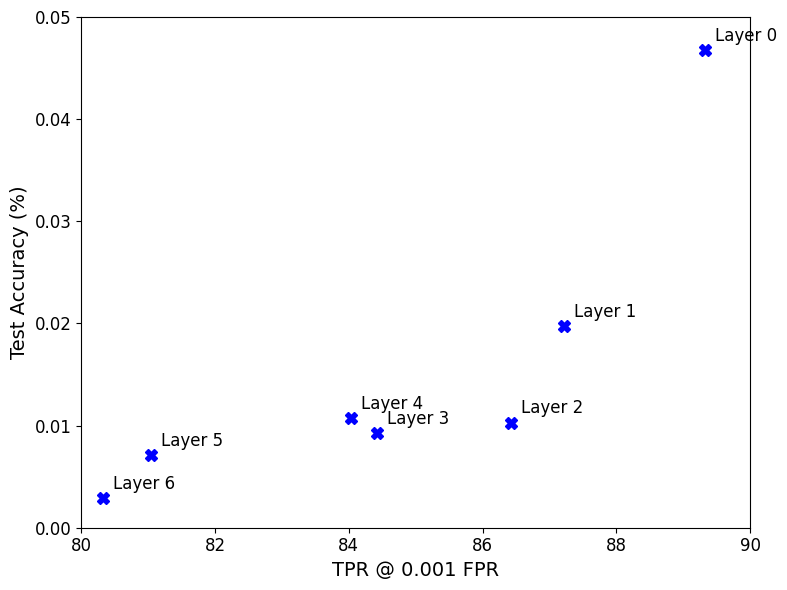

In [11]:

layers = list(range(7))
test_acc = [89.33, 87.22, 86.43, 84.42, 84.03, 81.04, 80.33]
tpr_0_001 = [0.0468, 0.0197, 0.0103, 0.0093, 0.0107, 0.0071, 0.0029]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(test_acc, tpr_0_001, marker='X', linestyle='', color='blue', markersize=8)

# Label points by layer
for acc, tpr, layer in zip(test_acc, tpr_0_001, layers):
    plt.text(acc+0.15, tpr+0.0005,f'Layer {layer}', fontsize=12, ha='left', va='bottom' )

# Labels and title
plt.ylabel('Test Accuracy (%)')
plt.xlabel('TPR @ 0.001 FPR')
plt.ylim(0, 0.05)
plt.xlim(80, 90)
plt.tight_layout()
plt.show()